#Introduction to Deep Learning: Basic Concepts, Neural Networks, and Convolutional Neural Networks

##Perceptron model

###Binary classification with perceptron

For this, we'll use the Iris dataset, which is inbuilt in the sklearn library.

In [64]:
from sklearn.linear_model import Perceptron
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import pandas as pd

In [65]:
# Load the iris dataset
iris = load_iris()

In [61]:
# Convert sklearn dataset to pandas dataframe
df = pd.DataFrame(data= iris.data, columns= iris.feature_names)

# Print the shape of the dataframe
print(f"The dataset has {df.shape[0]} rows and {df.shape[1]} columns.")

# Show the first 5 rows of the dataframe
print(df.head())

The dataset has 150 rows and 4 columns.
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0                5.1               3.5                1.4               0.2
1                4.9               3.0                1.4               0.2
2                4.7               3.2                1.3               0.2
3                4.6               3.1                1.5               0.2
4                5.0               3.6                1.4               0.2


In [66]:
# We'll only use two features and two classes for binary classification
X = iris.data[:100, :2]
y = iris.target[:100]

In [67]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [68]:
# Normalize feature data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [69]:
# Initialize and train the perceptron
clf = Perceptron(tol=1e-3, random_state=42)
clf.fit(X_train, y_train,)

Perceptron(random_state=42)

In [70]:
# Make predictions and evaluate the model
y_pred = clf.predict(X_test)
print('Accuracy: ', accuracy_score(y_test, y_pred))

Accuracy:  1.0


##Neural networks

###Stock price prediction

This script trains a simple neural network model using the historical closing prices of Apple's stock (obtained from Yahoo Finance) and uses the trained model to predict the next day's closing price. The prediction is made based on the closing prices of the previous 60 days.

The input to the model is a vector of the previous 60 days' closing prices, and the output is the predicted closing price for the next day. The model is trained using the Adam optimizer and the mean squared error loss function, which are commonly used for regression problems.

In [8]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import  Dropout, Dense
import yfinance as yf

In [9]:
# Load the data
data = yf.download('AAPL','2016-01-01','2023-07-01')

[*********************100%***********************]  1 of 1 completed


In [10]:
# Preprocess the data
# Scale data to range [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data.values.reshape(-1, 1))

In [11]:
# Prepare input data (use past 60 days' prices to predict the next day's)
X = []
y = []
for i in range(60, len(data)):
    X.append(data[i-60:i, 0])
    y.append(data[i, 0])
X, y = np.array(X), np.array(y)

In [12]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
# Create a neural network model
model = Sequential()
model.add(Dense(units=50, activation='relu', input_dim=60))
model.add(Dropout(0.2))
model.add(Dense(units=50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=1))

The model is compiled with the "adam" optimizer and the "mean_squared_error" loss function, as we're dealing with a regression problem.

In [14]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

The model is trained using the training data. We then use the model to predict the closing prices for the test data, and plot the predicted closing prices against the actual closing prices.

In [15]:
# Train the model
model.fit(X_train, y_train, epochs=1, batch_size=32)

282/282 [==============================] - 4s 7ms/step - loss: 0.0025


In [16]:
# Make predictions on the testing set
predicted_prices = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted_prices)  # inverse transform to get original scale

71/71 [==============================] - 1s 5ms/step


In [17]:
# Print predictions
print(predicted_prices)

[[-1448987.6]
 [  516659.8]
 [  700555.5]
 ...
 [ 2006521.5]
 [ 1486738. ]
 [-3127379.5]]


Finally, the accuracy of the model's predictions is displayed graphically using Matplotlib, where the x-axis represents the date and the y-axis represents the stock price.

In [18]:
y_test_unscaled = scaler.inverse_transform(y_test.reshape(-1, 1))

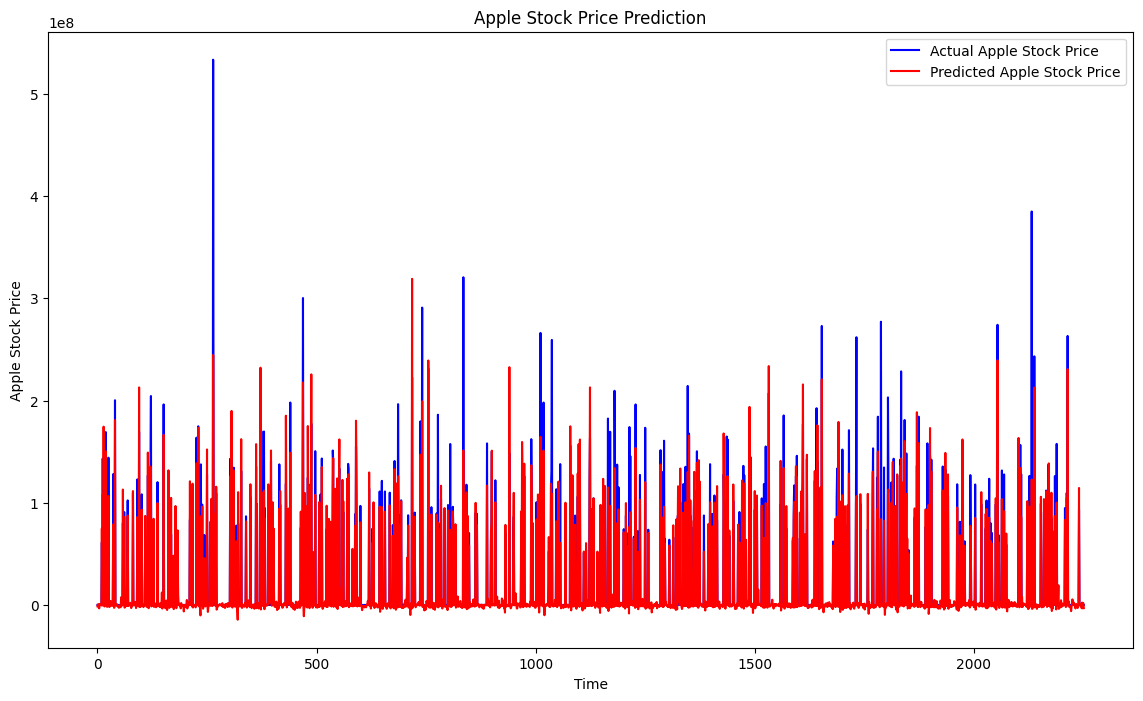

In [19]:
# Plot the actual vs. predicted values
plt.figure(figsize=(14, 8))
plt.plot(y_test_unscaled, color='blue', label='Actual Apple Stock Price')
plt.plot(predicted_prices, color='red', label='Predicted Apple Stock Price')
plt.title('Apple Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Apple Stock Price')
plt.legend()
plt.show()

##Feedforward Neural Networks

###Time series forecasting

We'll use a Multilayer Perceptron (MLP) model with multiple hidden layers to forecast the number of international airline passengers. We'll use the "international-airline-passengers.csv" dataset from the Machine Learning Mastery website. An MLP can be a powerful tool for time series forecasting because it can learn to recognize patterns over a sequence of inputs.

In [20]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [21]:
# Helper function to convert series to supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [22]:
# Load the dataset
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv'
dataframe = pd.read_csv(url, usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')

In [23]:
# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [24]:
# Convert time series to supervised learning problem
look_back = 3
supervised = series_to_supervised(dataset, look_back, 1)
train_size = int(len(supervised) * 0.67)
test_size = len(supervised) - train_size
train, test = supervised.values[0:train_size,:], supervised.values[train_size:len(supervised),:]

In [25]:
# Split into input (X) and output (Y) variables
trainX, trainY = train[:,0:look_back], train[:,look_back:]
testX, testY = test[:,0:look_back], test[:,look_back:]

In this code, an MLP model with two hidden layers is used for time series forecasting. The input dimension of the MLP is the number of lagged observations used to predict the current time step (look_back), and the output dimension is 1, as we're predicting a single value. The MLP is trained using the root mean squared error loss function, which is suitable for a regression problem like ours, and the efficient Adam version of stochastic gradient descent. The model is fit over 400 epochs with a batch size of 2.

In [26]:
# Build the MLP model
model = Sequential()
model.add(Dense(12, input_dim=look_back, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [27]:
# Fit the MLP model
model.fit(trainX, trainY, epochs=400, batch_size=2, verbose=2)

Epoch 1/400
47/47 - 2s - loss: 0.0514 - 2s/epoch - 38ms/step
Epoch 2/400
47/47 - 0s - loss: 0.0222 - 95ms/epoch - 2ms/step
Epoch 3/400
47/47 - 0s - loss: 0.0129 - 93ms/epoch - 2ms/step
Epoch 4/400
47/47 - 0s - loss: 0.0073 - 130ms/epoch - 3ms/step
Epoch 5/400
47/47 - 0s - loss: 0.0046 - 116ms/epoch - 2ms/step
Epoch 6/400
47/47 - 0s - loss: 0.0034 - 112ms/epoch - 2ms/step
Epoch 7/400
47/47 - 0s - loss: 0.0030 - 140ms/epoch - 3ms/step
Epoch 8/400
47/47 - 0s - loss: 0.0028 - 106ms/epoch - 2ms/step
Epoch 9/400
47/47 - 0s - loss: 0.0028 - 193ms/epoch - 4ms/step
Epoch 10/400
47/47 - 0s - loss: 0.0025 - 252ms/epoch - 5ms/step
Epoch 11/400
47/47 - 0s - loss: 0.0024 - 179ms/epoch - 4ms/step
Epoch 12/400
47/47 - 0s - loss: 0.0023 - 140ms/epoch - 3ms/step
Epoch 13/400
47/47 - 0s - loss: 0.0023 - 203ms/epoch - 4ms/step
Epoch 14/400
47/47 - 0s - loss: 0.0021 - 345ms/epoch - 7ms/step
Epoch 15/400
47/47 - 0s - loss: 0.0020 - 219ms/epoch - 5ms/step
Epoch 16/400
47/47 - 0s - loss: 0.0023 - 137ms/epoch 

In [28]:
# Make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

2/2 [==============================] - 0s 4ms/step


In [29]:
# Invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY)

Finally, we plot the actual and predicted values to visually evaluate the performance of the model. The blue line represents the original dataset, and the orange line represents the predicted values for the test dataset. We can visually evaluate how well our model performed in predicting the number of international airline passengers.

/usr/local/lib/python3.10/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


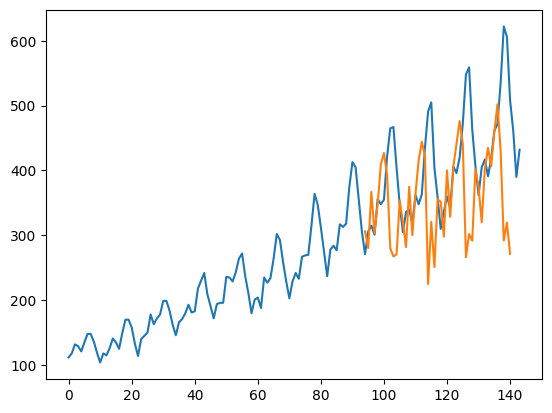

In [30]:
# Plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot([None for _ in trainPredict] + [x for x in testPredict])
plt.show()

##Convolutional neural network

###Image Recognition

We'll stick with the MNIST dataset, but this time we will implement a more complex version of a Convolutional Neural Network that includes additional convolutional and dense layers, as well as dropout for regularization. Dropout is a regularization technique where randomly selected neurons are ignored during training to prevent overfitting.

The MNIST dataset is a collection of handwritten digits (0 through 9). Each sample is a 28x28 grayscale image. This data is commonly used for image recognition tasks involving neural networks.

In [31]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.utils import to_categorical

In [32]:
# Load the MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [33]:
# Preprocess the data
X_train = X_train.reshape(-1, 28, 28, 1).astype('float32') / 255
X_test = X_test.reshape(-1, 28, 28, 1).astype('float32') / 255
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

We build a Sequential model in Keras, which is a linear stack of layers that we can add to one by one.

In [34]:
# Initialize the model
model = Sequential()

Conv2D layers are for convolution operations, extracting features from the input images.

In [35]:
# First convolutional layer, with 32 3x3 filters and ReLU activation
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))

MaxPooling2D layers are used to reduce the spatial dimensions (width, height) of the input volume for the next convolutional layer. They work by sliding a 2x2 pooling filter across the input volume and taking the max value among the 4 values in the 2x2 filter.

In [36]:
# Max pooling reduces the spatial dimensions of the output volume
model.add(MaxPooling2D(pool_size=(2, 2)))

Dropout layers "turn off" neurons during training to prevent overfitting.

In [37]:
# Regularization via dropout
model.add(Dropout(0.25))

In [38]:
# Second convolutional layer, with 64 3x3 filters and ReLU activation
model.add(Conv2D(64, (3, 3), activation='relu'))

In [39]:
# Second pooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))

In [40]:
# Regularization via dropout
model.add(Dropout(0.25))

The Flatten layer is used to flatten the input into a one-dimensional array.

In [41]:
# Flattening the tensor output from the previous layer to input it to the dense layer
model.add(Flatten())

Dense layers are fully connected layers, meaning all neurons in a layer are connected to those in the next layer. In the final Dense layer, the activation function is softmax, which makes the output sum up to 1 so the output can be interpreted as probabilities. The model will make its prediction based on which option has the highest probability.

In [42]:
# Dense layer of 128 neurons
model.add(Dense(128, activation='relu'))

In [43]:
# Another dropout
model.add(Dropout(0.5))

In [44]:
# Final softmax layer for classification
model.add(Dense(10, activation='softmax'))

In [45]:
# Compile the model with loss function, optimizer, and metrics
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [53]:
# Train the model
history=model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=200)

Epoch 1/10
300/300 [==============================] - 67s 223ms/step - loss: 0.0435 - accuracy: 0.9865 - val_loss: 0.0247 - val_accuracy: 0.9922
Epoch 2/10
300/300 [==============================] - 61s 203ms/step - loss: 0.0402 - accuracy: 0.9871 - val_loss: 0.0216 - val_accuracy: 0.9921
Epoch 3/10
300/300 [==============================] - 70s 234ms/step - loss: 0.0409 - accuracy: 0.9876 - val_loss: 0.0211 - val_accuracy: 0.9933
Epoch 4/10
300/300 [==============================] - 61s 204ms/step - loss: 0.0394 - accuracy: 0.9884 - val_loss: 0.0199 - val_accuracy: 0.9926
Epoch 5/10
300/300 [==============================] - 61s 204ms/step - loss: 0.0358 - accuracy: 0.9889 - val_loss: 0.0216 - val_accuracy: 0.9923
Epoch 6/10
300/300 [==============================] - 61s 203ms/step - loss: 0.0357 - accuracy: 0.9887 - val_loss: 0.0201 - val_accuracy: 0.9934
Epoch 7/10
300/300 [==============================] - 61s 203ms/step - loss: 0.0336 - accuracy: 0.9897 - val_loss: 0.0199 - val_ac

In [47]:
# import necessary libraries for visualization
import matplotlib.pyplot as plt
import numpy as np

In [48]:
# Evaluate the model
scores = model.evaluate(X_test, y_test, verbose=1)
print("Test loss:", scores[0])
print("Test accuracy:", scores[1])

313/313 [==============================] - 3s 10ms/step - loss: 0.0227 - accuracy: 0.9920
Test loss: 0.022742699831724167
Test accuracy: 0.9919999837875366


In [49]:
# Make predictions
predictions = model.predict(X_test)

313/313 [==============================] - 5s 17ms/step


In [50]:
# Choose a random test image
random_idx = np.random.choice(X_test.shape[0])

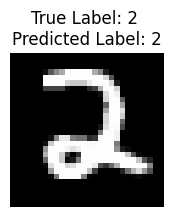

In [51]:
# Display the test image
plt.figure(figsize=(2, 2))
plt.imshow(X_test[random_idx].reshape(28, 28), cmap='gray')
plt.title("True Label: %s \nPredicted Label: %s" % (np.argmax(y_test[random_idx]), np.argmax(predictions[random_idx])))
plt.axis('off')
plt.show()

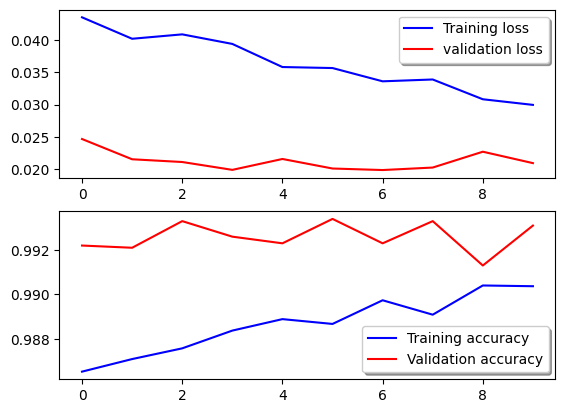

In [71]:
# Plot the loss and accuracy curves for training and validation
fig, ax = plt.subplots(2,1)
ax[0].plot(model.history.history['loss'], color='b', label="Training loss")
ax[0].plot(model.history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(model.history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(model.history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)
plt.show()